# **Glucose Regression**



### Google Colab Functions

#### Prevent random disconnects

This cell runs JS code to automatic reconnect to runtime.

Plots I can work on :


1.   Relationship between features and glyhb - done
2.   Distribution of data - done 
3.   Lasso feature selection -done



In [5]:
import IPython
from google.colab import output

display(IPython.display.Javascript('''
 function ClickConnect(){
   btn = document.querySelector("colab-connect-button")
   if (btn != null){
     console.log("Click colab-connect-button"); 
     btn.click() 
     }
   
   btn = document.getElementById('ok')
   if (btn != null){
     console.log("Click reconnect"); 
     btn.click() 
     }
  }
  
setInterval(ClickConnect,60000)
'''))

print("Done.")

<IPython.core.display.Javascript object>

Done.


In [6]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# Libraries Used

In [7]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score, make_scorer
from scipy.stats import norm


In [8]:
# Importing Dataset into Notebook
dataset =  pd.read_csv("/gdrive/MyDrive/Diabetes.csv")


# Data Analysis and Data Cleaning

After importing the data, a simple analysis of the data is done.

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403 entries, 0 to 402
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        403 non-null    int64  
 1   chol      402 non-null    float64
 2   stab.glu  403 non-null    int64  
 3   hdl       402 non-null    float64
 4   ratio     402 non-null    float64
 5   glyhb     390 non-null    float64
 6   location  403 non-null    object 
 7   age       403 non-null    int64  
 8   gender    403 non-null    object 
 9   height    398 non-null    float64
 10  weight    402 non-null    float64
 11  frame     391 non-null    object 
 12  bp.1s     398 non-null    float64
 13  bp.1d     398 non-null    float64
 14  bp.2s     141 non-null    float64
 15  bp.2d     141 non-null    float64
 16  waist     401 non-null    float64
 17  hip       401 non-null    float64
 18  time.ppn  400 non-null    float64
dtypes: float64(13), int64(3), object(3)
memory usage: 59.9+ KB


Since there are different numbers of data present in each features, We should check for NULL values.

### Check For The Null Values


In [10]:
dataset.isnull().sum()

id            0
chol          1
stab.glu      0
hdl           1
ratio         1
glyhb        13
location      0
age           0
gender        0
height        5
weight        1
frame        12
bp.1s         5
bp.1d         5
bp.2s       262
bp.2d       262
waist         2
hip           2
time.ppn      3
dtype: int64

In [11]:
# Lets view the data
dataset.head()

,id,chol,stab.glu,hdl,ratio,glyhb,location,age,gender,height,weight,frame,bp.1s,bp.1d,bp.2s,bp.2d,waist,hip,time.ppn
0,1000,203.0,82,56.0,3.6,4.31,Buckingham,46,female,62.0,121.0,medium,118.0,59.0,NaN,NaN,29.0,38.0,720.0
1,1001,165.0,97,24.0,6.9,4.44,Buckingham,29,female,64.0,218.0,large,112.0,68.0,NaN,NaN,46.0,48.0,360.0
2,1002,228.0,92,37.0,6.2,4.64,Buckingham,58,female,61.0,256.0,large,190.0,92.0,185.0,92.0,49.0,57.0,180.0
3,1003,78.0,93,12.0,6.5,4.63,Buckingham,67,male,67.0,119.0,large,110.0,50.0,NaN,NaN,33.0,38.0,480.0
4,1005,249.0,90,28.0,8.9,7.72,Buckingham,64,male,68.0,183.0,medium,138.0,80.0,NaN,NaN,44.0,41.0,300.0


Dropping the column "id" since it consists of unique value.

In [12]:
dataset.drop(columns = "id",inplace=True)

### Checking Dustribution

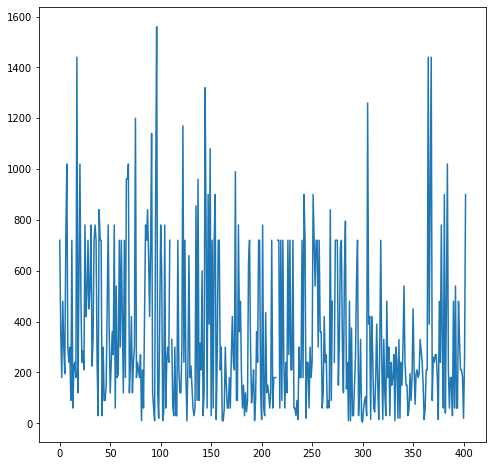

In [13]:
plt.figure(figsize=(8,8))
plt.plot(dataset["time.ppn"])
plt.show()

### Filling NAN Values as median of that columns

In [14]:
# Lets check the percentage of NaN values in our features
percent_missing = dataset.isnull().sum() * 100 / len(dataset)
missing_value_df = pd.DataFrame({'column_name': dataset.columns,
                                 'percent_missing': percent_missing})
missing_value_df

,column_name,percent_missing
chol,chol,0.248139
stab.glu,stab.glu,0.000000
hdl,hdl,0.248139
ratio,ratio,0.248139
glyhb,glyhb,3.225806
location,location,0.000000
age,age,0.000000
gender,gender,0.000000
height,height,1.240695
weight,weight,0.248139


We can clearly see that the coulumns **bp.2s** and **bp.2d** have over ***65%*** of NaN values in it,thus rendering the column useless. Therefore we will drop these 2 columns too.

In [15]:
dataset["weight"].fillna(dataset["weight"].median(),inplace=True)
dataset["height"].fillna(dataset["height"].median(),inplace=True)
dataset["hdl"].fillna(dataset["hdl"].median(),inplace=True)
dataset["ratio"].fillna(dataset["ratio"].median(),inplace=True)
dataset["bp.1s"].fillna(dataset["bp.1s"].median(),inplace=True)
dataset["bp.1d"].fillna(dataset["bp.1d"].median(),inplace=True)
dataset["chol"].fillna(dataset["chol"].median(),inplace=True)
dataset["waist"].fillna(dataset["waist"].median(),inplace=True)
dataset["hip"].fillna(dataset["hip"].median(),inplace=True)
dataset["time.ppn"].fillna(dataset["time.ppn"].median(),inplace=True)
dataset["frame"].fillna("medium",inplace=True)
dataset["glyhb"].fillna(dataset["glyhb"].median(),inplace=True)


In [16]:
# Deleting bp.2s , bp.2d Too many NAN values so dropping values
dataset.drop(columns=["bp.2s","bp.2d"],inplace=True)

In [17]:
dataset

,chol,stab.glu,hdl,ratio,glyhb,location,age,gender,height,weight,frame,bp.1s,bp.1d,waist,hip,time.ppn
0,203.0,82,56.0,3.6,4.310000,Buckingham,46,female,62.0,121.0,medium,118.0,59.0,29.0,38.0,720.0
1,165.0,97,24.0,6.9,4.440000,Buckingham,29,female,64.0,218.0,large,112.0,68.0,46.0,48.0,360.0
2,228.0,92,37.0,6.2,4.640000,Buckingham,58,female,61.0,256.0,large,190.0,92.0,49.0,57.0,180.0
3,78.0,93,12.0,6.5,4.630000,Buckingham,67,male,67.0,119.0,large,110.0,50.0,33.0,38.0,480.0
4,249.0,90,28.0,8.9,7.720000,Buckingham,64,male,68.0,183.0,medium,138.0,80.0,44.0,41.0,300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,296.0,369,46.0,6.4,16.110001,Louisa,53,male,69.0,173.0,medium,138.0,94.0,35.0,39.0,210.0
399,284.0,89,54.0,5.3,4.390000,Louisa,51,female,63.0,154.0,medium,140.0,100.0,32.0,43.0,180.0
400,194.0,269,38.0,5.1,13.630000,Louisa,29,female,69.0,167.0,small,120.0,70.0,33.0,40.0,20.0
401,199.0,76,52.0,3.8,4.490000,Louisa,41,female,63.0,197.0,medium,120.0,78.0,41.0,48.0,255.0


In [18]:
dataset.isnull().sum()

chol        0
stab.glu    0
hdl         0
ratio       0
glyhb       0
location    0
age         0
gender      0
height      0
weight      0
frame       0
bp.1s       0
bp.1d       0
waist       0
hip         0
time.ppn    0
dtype: int64

Now We are NULL free!

 Standardisation of all the columns as there must not be much diffrence in column values Very important for distance based values not much of a effect on trees based values

In [19]:
dataset["bp.1s"] = np.log(dataset["bp.1s"]) 
dataset["hdl"] = np.log(dataset["hdl"]) 
dataset["height"] = np.log(dataset["height"]) 
dataset["age"] = np.log(dataset["age"]) 
dataset["bp.1d"] = np.log(dataset["bp.1d"]) 
dataset["ratio"] = np.log(dataset["ratio"]) 
dataset["stab.glu"] = np.sqrt(dataset["stab.glu"])

In [20]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
sc = StandardScaler()
dataset["stab.glu"] =  sc.fit_transform(dataset["stab.glu"].values.reshape(403,1))
dataset['hdl'] = sc.fit_transform(dataset["hdl"].values.reshape(403,1))
dataset["ratio"] = sc.fit_transform(dataset["ratio"].values.reshape(403,1))
dataset['waist'] = sc.fit_transform(dataset["waist"].values.reshape(403,1))
dataset["weight"] = sc.fit_transform(dataset["weight"].values.reshape(403,1))
dataset["chol"] = sc.fit_transform(dataset["chol"].values.reshape(403,1))
dataset["bp.1s"] = sc.fit_transform(dataset["bp.1s"].values.reshape(403,1))
dataset["bp.1d"] = sc.fit_transform(dataset["bp.1d"].values.reshape(403,1))
dataset["time.ppn"] = sc.fit_transform(dataset["time.ppn"].values.reshape(403,1))
dataset["hip"] = sc.fit_transform(dataset["hip"].values.reshape(403,1))
dataset["age"] = sc.fit_transform(dataset["age"].values.reshape(403,1))
dataset["height"] = sc.fit_transform(dataset["height"].values.reshape(403,1))

In [21]:
dataset

,chol,stab.glu,hdl,ratio,glyhb,location,age,gender,height,weight,frame,bp.1s,bp.1d,waist,hip,time.ppn
0,-0.109082,-0.498023,0.485298,-0.476985,4.310000,Buckingham,0.125395,female,-1.033326,-1.406006,medium,-0.864244,-2.026457,-1.558395,-0.893303,1.231660
1,-0.966182,-0.123024,-2.111356,1.396400,4.440000,Buckingham,-1.129342,female,-0.496206,1.004457,large,-1.196269,-1.159206,1.419726,0.880976,0.063298
2,0.454799,-0.244575,-0.784788,1.088371,4.640000,Buckingham,0.755834,female,-1.308419,1.948762,large,2.166407,0.687334,1.945276,2.477827,-0.520882
3,-2.928491,-0.220006,-4.235595,1.224437,4.630000,Buckingham,1.148155,male,0.278792,-1.455706,large,-1.310909,-3.037533,-0.857660,-0.893303,0.452752
4,0.928460,-0.294119,-1.638941,2.129326,7.720000,Buckingham,1.023565,male,0.529432,0.134703,medium,0.131908,-0.166428,1.069359,-0.361020,-0.131429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,1.988557,4.300799,-0.117546,1.179792,16.110001,Louisa,0.510647,male,0.776412,-0.113799,medium,0.131908,0.818708,-0.507293,-0.715875,-0.423519
399,1.717894,-0.319097,0.373845,0.636739,4.390000,Louisa,0.406029,female,-0.762634,-0.585951,medium,0.223454,1.196686,-1.032844,-0.006164,-0.520882
400,-0.312080,2.973653,-0.703059,0.525974,13.630000,Louisa,-1.129342,female,0.776412,-0.262900,small,-0.757310,-0.982130,-0.857660,-0.538447,-1.040154
401,-0.199303,-0.657568,0.258185,-0.321297,4.490000,Louisa,-0.187563,female,-0.762634,0.482604,medium,-0.757310,-0.321087,0.543808,0.880976,-0.277474


### Checking Distribution

Text(0, 0.5, 'Frequency')

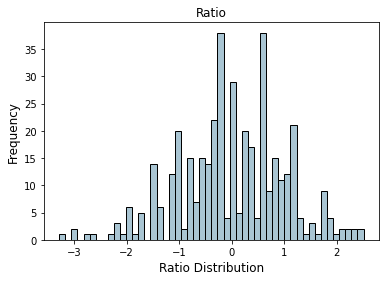

In [22]:
fig,ax = plt.subplots()
dataset["bp.1d"].hist(bins=50,color='#A9C5D3',edgecolor='black',grid=False)
ax.set_title('Ratio', fontsize=12)
ax.set_xlabel('Ratio Distribution', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'Frequency')

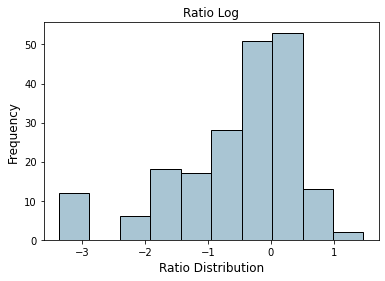

In [23]:
fig,ax = plt.subplots()
np.log(dataset["ratio"]).hist(bins=10,color='#A9C5D3',edgecolor='black',grid=False)
ax.set_title('Ratio Log', fontsize=12)
ax.set_xlabel('Ratio Distribution', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

<Figure size 1440x720 with 0 Axes>

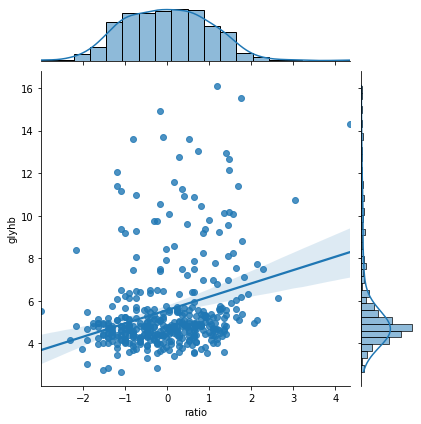

In [24]:
plt.figure(figsize=(20,10))
sns.jointplot(x=dataset["ratio"],y=dataset["glyhb"],kind="reg")
plt.show()

<Figure size 1440x720 with 0 Axes>

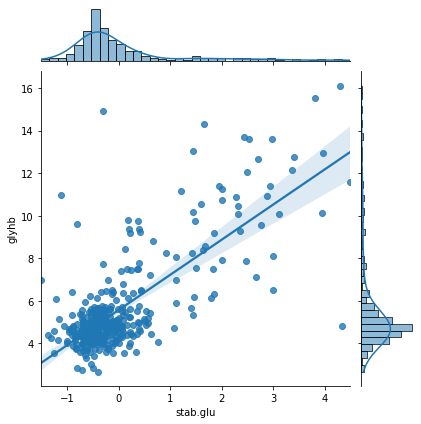

In [25]:
## Plot relation ship between glyhb and stab.glu
plt.figure(figsize=(20,10))
sns.jointplot(x=dataset["stab.glu"],y=dataset["glyhb"],kind="reg")
plt.show()

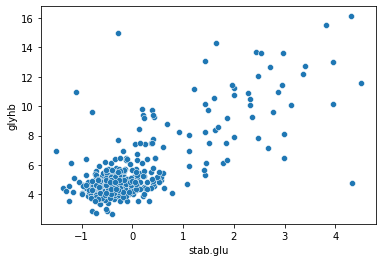

In [26]:
sns.scatterplot(data=dataset, x=dataset['stab.glu'], y=dataset['glyhb'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


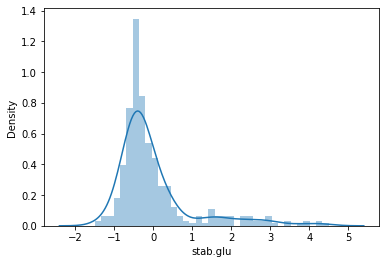

In [27]:
# Distrubution of stab.glu
sns.distplot(dataset['stab.glu']);

In [28]:
print("Skewness: %f" % dataset['stab.glu'].skew())
print("Kurtosis: %f" % dataset['stab.glu'].kurt())

Skewness: 2.202467
Kurtosis: 5.031123


In [29]:
# Creating Y 
y = dataset["glyhb"]
dataset.drop(columns="glyhb",inplace=True)

In [30]:
dataset

,chol,stab.glu,hdl,ratio,location,age,gender,height,weight,frame,bp.1s,bp.1d,waist,hip,time.ppn
0,-0.109082,-0.498023,0.485298,-0.476985,Buckingham,0.125395,female,-1.033326,-1.406006,medium,-0.864244,-2.026457,-1.558395,-0.893303,1.231660
1,-0.966182,-0.123024,-2.111356,1.396400,Buckingham,-1.129342,female,-0.496206,1.004457,large,-1.196269,-1.159206,1.419726,0.880976,0.063298
2,0.454799,-0.244575,-0.784788,1.088371,Buckingham,0.755834,female,-1.308419,1.948762,large,2.166407,0.687334,1.945276,2.477827,-0.520882
3,-2.928491,-0.220006,-4.235595,1.224437,Buckingham,1.148155,male,0.278792,-1.455706,large,-1.310909,-3.037533,-0.857660,-0.893303,0.452752
4,0.928460,-0.294119,-1.638941,2.129326,Buckingham,1.023565,male,0.529432,0.134703,medium,0.131908,-0.166428,1.069359,-0.361020,-0.131429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,1.988557,4.300799,-0.117546,1.179792,Louisa,0.510647,male,0.776412,-0.113799,medium,0.131908,0.818708,-0.507293,-0.715875,-0.423519
399,1.717894,-0.319097,0.373845,0.636739,Louisa,0.406029,female,-0.762634,-0.585951,medium,0.223454,1.196686,-1.032844,-0.006164,-0.520882
400,-0.312080,2.973653,-0.703059,0.525974,Louisa,-1.129342,female,0.776412,-0.262900,small,-0.757310,-0.982130,-0.857660,-0.538447,-1.040154
401,-0.199303,-0.657568,0.258185,-0.321297,Louisa,-0.187563,female,-0.762634,0.482604,medium,-0.757310,-0.321087,0.543808,0.880976,-0.277474


### Splitting train and test values

In [31]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(dataset,y,test_size=0.2,random_state=42)

In [32]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((322, 15), (322,), (81, 15), (81,))

In [33]:
x_train

,chol,stab.glu,hdl,ratio,location,age,gender,height,weight,frame,bp.1s,bp.1d,waist,hip,time.ppn
353,-0.041417,-0.472007,1.080314,-1.001985,Louisa,0.458841,male,0.776412,-0.610801,small,0.223454,1.073274,-0.332110,-0.538447,-0.472201
233,-0.266969,0.290480,0.797224,-0.816145,Louisa,0.352171,male,0.278792,-0.933853,medium,1.679430,1.778906,-0.507293,-1.070731,-0.910336
3,-2.928491,-0.220006,-4.235595,1.224437,Buckingham,1.148155,male,0.278792,-1.455706,large,-1.310909,-3.037533,-0.857660,-0.893303,0.452752
18,-0.312080,-0.524198,-0.868755,0.690563,Louisa,-0.541273,male,-0.496206,-1.281755,medium,-1.310909,-0.479763,-1.383211,-1.603015,-0.715609
131,-0.447411,-0.630551,-0.184903,-0.033104,Louisa,-0.947960,female,0.278792,1.228108,medium,-0.652145,-0.982130,1.594909,1.768115,-0.650700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,-0.988738,-0.394885,-0.545865,-0.102494,Buckingham,-1.759782,female,0.776412,1.675411,large,-0.446889,-0.560674,1.069359,0.703548,0.258025
106,1.920891,-0.420440,2.072602,-0.907566,Louisa,-0.947960,female,0.278792,0.557155,medium,-1.310909,0.553072,0.543808,-0.183592,-0.326155
270,-1.372177,-0.394885,-1.043925,0.034653,Buckingham,-0.394224,male,0.776412,0.681405,small,-0.248049,0.947317,0.193441,-0.361020,0.452752
348,-1.936059,-0.498023,-0.324229,-1.200652,Louisa,-0.541273,female,1.259812,0.134703,medium,-1.310909,-0.166428,0.543808,0.348692,-0.812973


### Unique Values Preprocessing

In [34]:
x_train["location"].unique()

array(['Louisa', 'Buckingham'], dtype=object)

In [35]:
x_train["gender"].unique()

array(['male', 'female'], dtype=object)

In [36]:
x_train["frame"].unique()

array(['small', 'medium', 'large'], dtype=object)

### Label Encoding

In [37]:
from sklearn.preprocessing import LabelEncoder

In [38]:
le = LabelEncoder()

In [39]:
combine = x_train.append(x_test)

In [40]:
combine.shape

(403, 15)

In [41]:
combine["location"] = le.fit_transform(combine["location"])

In [42]:
combine["gender"] = le.fit_transform(combine["gender"])

In [43]:
combine["frame"] = le.fit_transform(combine["frame"])

#Feature Importance

In [44]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

### Tree

In [45]:
from sklearn.ensemble import RandomForestRegressor
# define the model
model = RandomForestRegressor()
# fit the model
model.fit(combine, y)
# get importance
importance = model.feature_importances_
print(importance)

[0.09268437 0.13731439 0.05814658 0.08284387 0.01357137 0.09611538
 0.00698205 0.05881508 0.07356992 0.0216631  0.0746288  0.07111601
 0.07052907 0.07345457 0.06856545]


In [46]:
feature_importances = pd.DataFrame(importance, index =combine.columns,  columns=['importance']).sort_values('importance', ascending=False)

In [47]:
feature_importances

,importance
stab.glu,0.137314
age,0.096115
chol,0.092684
ratio,0.082844
bp.1s,0.074629
weight,0.073570
hip,0.073455
bp.1d,0.071116
waist,0.070529
time.ppn,0.068565


In [48]:
coef = pd.Series(model.feature_importances_, index = combine.columns)

Text(0.5, 1.0, 'Coefficients in the Random Forest Model')

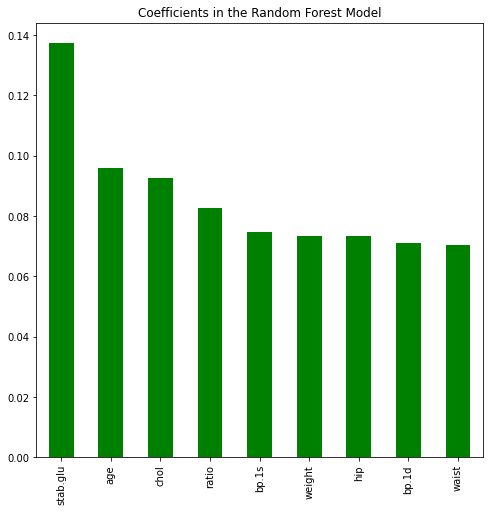

In [49]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
coef.nlargest(9).plot(kind = "bar",color='green')
plt.title("Coefficients in the Random Forest Model")

### One Hot Encoding

In [50]:
#from sklearn.preprocessing import OneHotEncoder

In [51]:
#combine = pd.concat([combine,pd.get_dummies(combine["frame"])],axis=1)
#combine.drop(columns="frame",inplace=True)

In [52]:
combine.drop(columns=["frame","waist","hdl","height","location","gender"],inplace=True)

In [53]:
combine

,chol,stab.glu,ratio,age,weight,bp.1s,bp.1d,hip,time.ppn
353,-0.041417,-0.472007,-1.001985,0.458841,-0.610801,0.223454,1.073274,-0.538447,-0.472201
233,-0.266969,0.290480,-0.816145,0.352171,-0.933853,1.679430,1.778906,-1.070731,-0.910336
3,-2.928491,-0.220006,1.224437,1.148155,-1.455706,-1.310909,-3.037533,-0.893303,0.452752
18,-0.312080,-0.524198,0.690563,-0.541273,-1.281755,-1.310909,-0.479763,-1.603015,-0.715609
131,-0.447411,-0.630551,-0.033104,-0.947960,1.228108,-0.652145,-0.982130,1.768115,-0.650700
...,...,...,...,...,...,...,...,...,...
45,0.793128,-1.369639,-0.102494,-0.466755,1.377209,-1.310909,-0.015589,2.477827,-0.812973
90,-1.101514,-0.344215,-0.398089,-0.394224,-0.213199,0.131908,-0.243268,-0.538447,1.134296
248,0.657797,0.356161,0.636739,1.381418,-0.088949,1.152068,-0.560674,0.171264,-0.131429
337,1.199123,-0.028022,-0.907566,0.458841,0.507454,0.746684,0.687334,1.058404,-1.040154


### Separation OF Train And Test after using embedding

In [54]:
x_train = combine.iloc[:322]
x_test = combine.iloc[322:]

In [55]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((322, 9), (322,), (81, 9), (81,))

In [56]:
# data now
x_train.head()

,chol,stab.glu,ratio,age,weight,bp.1s,bp.1d,hip,time.ppn
353,-0.041417,-0.472007,-1.001985,0.458841,-0.610801,0.223454,1.073274,-0.538447,-0.472201
233,-0.266969,0.290480,-0.816145,0.352171,-0.933853,1.679430,1.778906,-1.070731,-0.910336
3,-2.928491,-0.220006,1.224437,1.148155,-1.455706,-1.310909,-3.037533,-0.893303,0.452752
18,-0.312080,-0.524198,0.690563,-0.541273,-1.281755,-1.310909,-0.479763,-1.603015,-0.715609
131,-0.447411,-0.630551,-0.033104,-0.947960,1.228108,-0.652145,-0.982130,1.768115,-0.650700


In [57]:
## Metric Table Function
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from prettytable import PrettyTable

def metrics(y_test,y_pred):
    r2score = r2_score(y_test,y_pred)
    MAD = np.mean(np.abs(y_pred-np.mean(y_test)))
    MAE = mean_absolute_error(y_test,y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test,y_pred))
    MSE=mean_squared_error(y_test,y_pred)
    t = PrettyTable(['Error Metric', 'Value'])
    t.add_row(["r2_score",r2score])
    t.add_row(["MSE",MSE])
    t.add_row(['MAE', MAE])
    t.add_row(["RMSE",RMSE,])
    t.add_row(["MAD",MAD])
    return t,r2score,MAD,MAE,RMSE,MSE

In [58]:
# Lets create a table for storing data 

df = pd.DataFrame(columns=["Model","R2score","MSE","MAE","MAD","RMSE"])
# Data for storing the weights
df_weights = pd.DataFrame(columns = ["Ridge","Linear Reg","Lasso","ANN"])

# Machine Learning

## Models used for this Ensemble
1. Ridge()
2. ANN
3. Lasso
4. Linear Reg


##1. Ridge Regression :

In [59]:
### Ridge
from sklearn.linear_model import Ridge
ridge_reg = Ridge()
from sklearn.model_selection import GridSearchCV
params_Ridge = {'alpha': [1,0.1,0.01,0.001,0.0001,0] , "fit_intercept": [True, False], "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
Ridge_GS = GridSearchCV(ridge_reg, param_grid=params_Ridge, n_jobs=-1, cv=10)
Ridge_GS.fit(x_train,y_train)
print(Ridge_GS.best_params_)
Ridge_best_model = Ridge_GS.best_estimator_
Ridge_best_model.fit(x_train,y_train)

{'alpha': 1, 'fit_intercept': True, 'solver': 'saga'}


Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='saga', tol=0.001)

In [60]:
y_Ridge_GS_pred= Ridge_best_model.predict(x_test)

In [61]:
t,r2score,MAD,MAE,RMSE,MSE = metrics(y_test,y_Ridge_GS_pred)
df.loc[len(df.index)] = ["Ridge",r2score,MSE,MAE,MAD,RMSE]

In [62]:
# Metric table
print(t)

+--------------+--------------------+
| Error Metric |       Value        |
+--------------+--------------------+
|   r2_score   | 0.8073796043905681 |
|     MSE      | 1.0392481098540232 |
|     MAE      | 0.7622254015790835 |
|     RMSE     | 1.0194351915909237 |
|     MAD      |  1.29813981786459  |
+--------------+--------------------+


## 2. Linear Regression

In [63]:
from sklearn.linear_model import LinearRegression
model_lr = LinearRegression()
params_lr = {"fit_intercept": [True, False]}
lr_GS = GridSearchCV(model_lr, param_grid=params_lr, n_jobs=-1,cv=10)
lr_GS.fit(x_train,y_train)
print(lr_GS.best_params_)
Lr_best_model = lr_GS.best_estimator_
Lr_best_model.fit(x_train,y_train)

{'fit_intercept': True}


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [64]:
y_lr_GS_pred= Lr_best_model.predict(x_test)
t,r2score,MAD,MAE,RMSE,MSE = metrics(y_test,y_lr_GS_pred)
df.loc[len(df.index)] = ["Linear Reg",r2score,MSE,MAE,MAD,RMSE]
print(t)

+--------------+--------------------+
| Error Metric |       Value        |
+--------------+--------------------+
|   r2_score   | 0.8078997940731456 |
|     MSE      | 1.0364415215762148 |
|     MAE      | 0.762101101310602  |
|     RMSE     | 1.0180577201594292 |
|     MAD      | 1.3020520821124373 |
+--------------+--------------------+


## 3. Lasso

In [65]:
# lasso
from sklearn.linear_model import Lasso
lasso_reg = Lasso()
params_lasso = {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03] , "fit_intercept": [True, False]}
lasso_GS = GridSearchCV(lasso_reg, param_grid=params_lasso, n_jobs=-1,cv=10)
lasso_GS.fit(x_train,y_train)
print(lasso_GS.best_params_)
Lasso_best_model = lasso_GS.best_estimator_
Lasso_best_model.fit(x_train,y_train)

{'alpha': 0.03, 'fit_intercept': True}


Lasso(alpha=0.03, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [66]:
y_lasso_GS_pred= Lasso_best_model.predict(x_test)

In [ ]:
t,r2score,MAD,MAE,RMSE,MSE = metrics(y_test,y_lasso_GS_pred)
df.loc[len(df.index)] = ["Lasso",r2score,MSE,MAE,MAD,RMSE]
print(t)

+--------------+--------------------+
| Error Metric |       Value        |
+--------------+--------------------+
|   r2_score   | 0.8059940600121166 |
|     MSE      | 1.0467235611003405 |
|     MAE      | 0.7695319336334419 |
|     RMSE     | 1.023095088982613  |
|     MAD      | 1.2643779177776455 |
+--------------+--------------------+


## 5. SVR

In [67]:
from sklearn.svm import SVR
svr_gs = SVR()
param_svr = {'kernel' : ('linear', 'poly', 'rbf', 'sigmoid'),'C' : [1,5,10],'degree' : [3,8],
             'coef0' : [0.01,10,0.5],'gamma' : ('auto','scale')}
Svr_grid= GridSearchCV(estimator = svr_gs, param_grid = param_svr, cv = 10, n_jobs = -1, verbose = 2)
Svr_grid.fit(x_train,y_train)
print(Svr_grid.best_params_)
SVR_best_model = Svr_grid.best_estimator_
SVR_best_model.fit(x_train,y_train)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 521 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 998 tasks      | elapsed:  4.0min


{'C': 1, 'coef0': 0.01, 'degree': 3, 'gamma': 'auto', 'kernel': 'linear'}


[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  7.8min finished


SVR(C=1, cache_size=200, coef0=0.01, degree=3, epsilon=0.1, gamma='auto',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [68]:
y_svr=SVR_best_model.predict(x_test)

In [69]:
t,r2score,MAD,MAE,RMSE,MSE = metrics(y_test,y_svr)
print(t)

+--------------+--------------------+
| Error Metric |       Value        |
+--------------+--------------------+
|   r2_score   | 0.7656081489291227 |
|     MSE      | 1.2646183568458378 |
|     MAE      | 0.7814313361649005 |
|     RMSE     | 1.1245525140454036 |
|     MAD      | 1.2290411568976816 |
+--------------+--------------------+


## 4. ANN

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasRegressor

In [ ]:
# # Function to create model, required for KerasClassifier
# def create_model():
#   model = Sequential()
#   model.add(Dense(6, input_dim=9, kernel_initializer='normal', activation='relu'))
#   model.add(Dense(3, activation='relu'))
#   model.add(Dense(1, activation='linear'))
#   model.compile(loss='mse', optimizer='adam', metrics=['mse'])
#   mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
#   return model

# # create model
# model = KerasRegressor(build_fn=create_model, verbose=1)
# # define the grid search parameters

# batch_size = [5, 10, 20, 40, 60, 80, 100]
# epochs = [10, 50, 100]


# param_grid = dict(batch_size=batch_size, epochs=epochs)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
# grid_result = grid.fit(x_train, y_train)

In [ ]:
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# model = Sequential()
# model.add(Dense(6, input_dim=9, kernel_initializer='normal', activation='relu'))
# model.add(Dense(3, activation='relu'))
# model.add(Dense(1, activation='linear'))
# model.summary()

In [ ]:
# # Compile model
# model.compile(loss='mse', optimizer='adam', metrics=['mse'])
# mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
#history=model.fit(x_train, y_train, epochs=50, batch_size=5, verbose=1, validation_split=0.2,callbacks=[mc])

In [ ]:
saved_model = load_model('/gdrive/MyDrive/best_model.h5')

y_ann_pred = saved_model.predict(x_test)
score = saved_model.evaluate(x_test,y_test, verbose=1)

t,r2score,MAD,MAE,RMSE,MSE = metrics(y_test,y_ann_pred)
df.loc[len(df.index)] = ["ANN",r2score,MSE,MAE,MAD,RMSE]
print(t)

3/3 [==============================] - 6s 3ms/step - loss: 1.0557 - mse: 1.0557
+--------------+--------------------+
| Error Metric |       Value        |
+--------------+--------------------+
|   r2_score   | 0.8043222777925207 |
|     MSE      | 1.0557433562591323 |
|     MAE      | 0.7344105772020009 |
|     RMSE     | 1.0274937256543868 |
|     MAD      |     1.2282964      |
+--------------+--------------------+


In [ ]:
history=saved_model.history

In [ ]:
history.history

{}

In [ ]:
# print(history.history.keys())
# # "Loss"
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# plt.show()

In [ ]:
y_ann_pred=y_ann_pred.reshape((81,))

In [ ]:
y_ann_pred.shape

(81,)

In [ ]:
df

,Model,R2score,MSE,MAE,MAD,RMSE
0,Ridge,0.807426,1.038995,0.762401,1.298893,1.019311
1,Linear Reg,0.807900,1.036442,0.762101,1.302052,1.018058
2,Lasso,0.805994,1.046724,0.769532,1.264378,1.023095
3,ANN,0.804322,1.055743,0.734411,1.228296,1.027494


## Ensemble Learning with Average weights

In [ ]:
Ensemble_average_prediction_1 = (y_ann_pred + y_lr_GS_pred+ y_lasso_GS_pred+  + y_Ridge_GS_pred ) / 4
t,r2score,MAD,MAE,RMSE,MSE = metrics(y_test,Ensemble_average_prediction_1)
df.loc[len(df.index)] = ["Ensemble with AVG",r2score,MSE,MAE,MAD,RMSE]
print(t)

+--------------+--------------------+
| Error Metric |       Value        |
+--------------+--------------------+
|   r2_score   | 0.8121820924241245 |
|     MSE      | 1.0133371641533924 |
|     MAE      | 0.7394892834966859 |
|     RMSE     | 1.0066464941345559 |
|     MAD      | 1.269054853573645  |
+--------------+--------------------+


## Ensemble Learning with Optimzed Weights for
1. Ridge()
2. ANN
3. Lasso
4. Linear Reg


In [ ]:
from scipy.optimize import minimize

In [ ]:
rmse_optimize =[]

In [ ]:
def rmse_loss_func(weights):
    ''' scipy minimize will pass the weights as a numpy array '''
    final_prediction = 0
    for weight, prediction in zip(weights, predictions):
            final_prediction += weight*prediction

    print(np.sqrt(mean_squared_error(y_test,final_prediction)),weights)
    rmse_optimize.append(np.sqrt(mean_squared_error(y_test,final_prediction)))
    return np.sqrt(mean_squared_error(y_test,final_prediction))

In [ ]:
# add every model's prediction into list
predictions = []
predictions.append(y_Ridge_GS_pred)
predictions.append(y_ann_pred)
predictions.append(y_lasso_GS_pred)
predictions.append(y_lr_GS_pred)
#starting Value
starting_values = [0.5]*len(predictions)
#cons = ({'type':'eq','fun':lambda w: 1-sum(w)})
#our weights are bound between 0 and 1
bounds = [(0,1)]*len(predictions)
res = minimize(rmse_loss_func, starting_values, method='Powell')

5.945198192249125 [0.5 0.5 0.5 0.5]
5.945198192249125 [0.5 0.5 0.5 0.5]
11.913649487434935 [1.5 0.5 0.5 0.5]
3.989785876486906 [-1.118034  0.5       0.5       0.5     ]
1.409341475486176 [-0.6413661  0.5        0.5        0.5      ]
1.409341475486176 [-0.6413661  0.5        0.5        0.5      ]
1.9021068272745543 [-0.20540306  0.5         0.5         0.5       ]
2.3173385185476656 [-0.82343703  0.5         0.5         0.5       ]
0.9947675049548671 [-0.48048115  0.5         0.5         0.5       ]
0.9960250654343182 [-0.46531981  0.5         0.5         0.5       ]
0.9983921841909147 [-0.49028596  0.5         0.5         0.5       ]
0.9947675049548671 [-0.48048115  0.5         0.5         0.5       ]
5.93096380659327 [-0.48048115  1.5         0.5         0.5       ]
9.59961808867216 [-0.48048115 -1.118034    0.5         0.5       ]
0.9947675049548671 [-0.48048115  0.5         0.5         0.5       ]
3.7999802190284386 [-0.48048115 -0.11803397  0.5         0.5       ]
2.425856793201416

In [ ]:

g = sns.relplot(x=range(len(rmse_optimize)), y=rmse_optimize, kind="line")
g.fig.set_size_inches(10,8)
plt.title("RMSE Weights Optimization using Powell algorithm)
plt.ylabel('RMSE')
plt.xlabel('Number of Iterations')
g.fig.autofmt_xdate()


SyntaxError: ignored

In [ ]:
print('Ensemble Score: {best_score}'.format(best_score=res['fun']))
print('Best Weights: {weights}'.format(weights=res['x']))

Ensemble Score: 0.9941984446698354
Best Weights: [-0.48052461  0.50593806  0.49911355  0.50047035]


1. Ridge()
2. ANN
3. Lasso
4. Linear Reg


In [ ]:
best_weights=res["x"]

In [ ]:
w1,w2,w3,w4 = best_weights[0],best_weights[1],best_weights[2],best_weights[3]
w1

-0.48052460728723473

In [ ]:
df_weights.loc[len(df.index)] = [w1,w4,w3,w2]

In [ ]:
#df_weights.to_csv("Weights.csv")

In [ ]:
Ensemble_average_prediction_2 = ( y_lr_GS_pred*w4+ y_lasso_GS_pred*w3 + y_ann_pred*w2 +
                                 y_Ridge_GS_pred*w1)
t,r2score,MAD,MAE,RMSE,MSE = metrics(y_test,Ensemble_average_prediction_2)
df.loc[len(df.index)] = ["Ensemble with Opt Weights",r2score,MSE,MAE,MAD,RMSE]
print(t)

+--------------+--------------------+
| Error Metric |       Value        |
+--------------+--------------------+
|   r2_score   | 0.8167984321893247 |
|     MSE      | 0.9884305473839203 |
|     MAE      |  0.74112686709868  |
|     RMSE     | 0.9941984446698356 |
|     MAD      | 1.2111301373774852 |
+--------------+--------------------+


In [ ]:
df

,Model,R2score,MSE,MAE,MAD,RMSE
0,Ridge,0.807426,1.038995,0.762401,1.298893,1.019311
1,Linear Reg,0.807900,1.036442,0.762101,1.302052,1.018058
2,Lasso,0.805994,1.046724,0.769532,1.264378,1.023095
3,ANN,0.804322,1.055743,0.734411,1.228296,1.027494
4,Ensemble with AVG,0.812182,1.013337,0.739489,1.269055,1.006646
5,Ensemble with Opt Weights,0.816798,0.988431,0.741127,1.211130,0.994198


In [ ]:
#df.to_csv("Model Data.csv")

## Model Comparison Charts


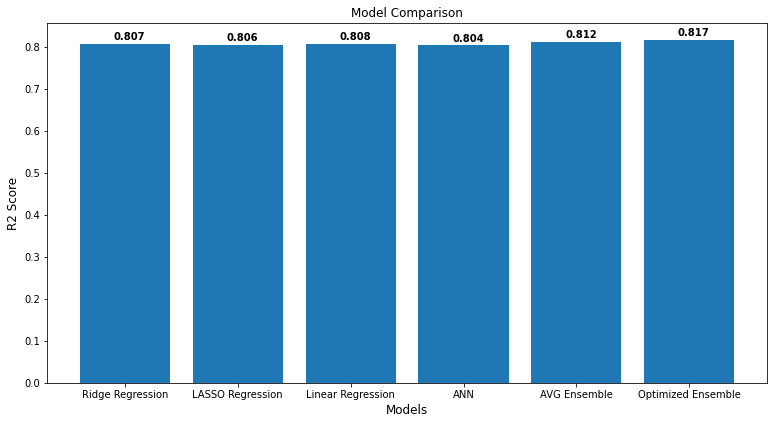

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
models = ['Ridge Regression', 'LASSO Regression', 'Linear Regression', 'ANN', 'AVG Ensemble','Optimized Ensemble']

r2_score_list = [round(r2_score(y_test,y_Ridge_GS_pred),3),
                 round(r2_score(y_test,y_lasso_GS_pred),3),
                 round(r2_score(y_test,y_lr_GS_pred),3),
                 round(r2_score(y_test,y_ann_pred),3),
                 round(r2_score(y_test,Ensemble_average_prediction_1),3),
                 round(r2_score(y_test,Ensemble_average_prediction_2),3)]

ax.bar(models,r2_score_list)
ax.set_ylabel('R2 Score',fontsize= 12)
ax.set_xlabel('Models',fontsize= 12)
ax.set_title('Model Comparison')
for i, v in enumerate(r2_score_list):
  ax.text(i - 0.1,v + 0.01, str(v), color='black', fontweight='bold')
#plt.savefig('barplot_1.png',dpi=200, format='png', bbox_inches='tight')
plt.show()

In [ ]:
!pip install regressormetricgraphplot

In [ ]:
from regressormetricgraphplot import CompareModels

In [ ]:
plot = CompareModels()
plot.add(model_name='Ridge Regression', y_test=y_test, y_pred=y_Ridge_GS_pred)
#plot.show(figsize=(10, 5))

In [ ]:
plot.add(model_name='LASSO Regression', y_test=y_test, y_pred=y_lasso_GS_pred)
plot.add(model_name='Linear Regression', y_test=y_test, y_pred=y_lr_GS_pred)
plot.add(model_name='ANN', y_test=y_test, y_pred=y_ann_pred)

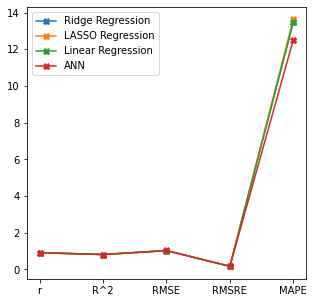

In [ ]:
plot.show(figsize=(5,5))

In [ ]:
plot.add(model_name='Ensemble Model', y_test=y_test, y_pred=Ensemble_average_prediction_2)

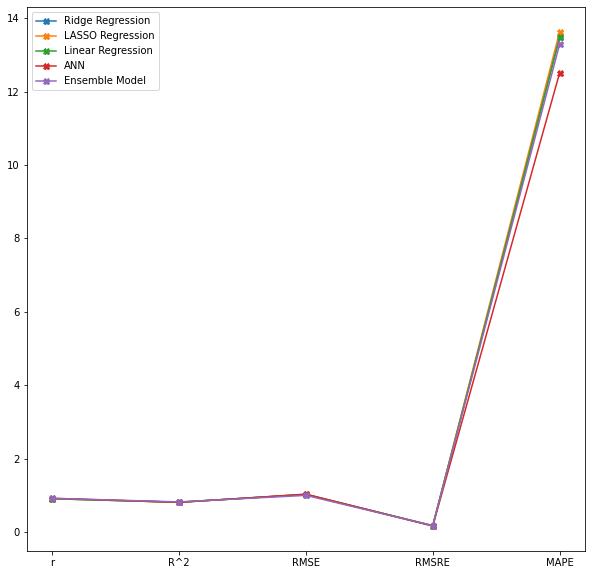

In [ ]:
plot.show(figsize=(10, 10))

In [ ]:
y_test_array=y_test.to_numpy()
y_test_array

array([ 4.59000015,  4.86999989,  4.42999983,  5.65999985,  4.38000011,
        4.28999996,  6.48999977,  4.96000004,  9.27999973,  7.21999979,
       10.06999969,  3.93000007,  4.67000008,  4.6500001 , 12.97000027,
        5.05000019,  8.81000042,  5.36000013,  5.78000021,  4.30999994,
        6.3499999 , 16.11000061,  4.13999987,  5.38000011,  4.80999994,
        6.78000021,  5.28000021, 10.09000015,  4.96000004,  3.41000009,
        5.09000015,  4.84000015,  4.30999994,  4.82999992,  4.23999977,
        4.67999983,  5.19999981,  4.19999981,  5.51999998,  4.94999981,
        5.03000021,  4.82999992,  4.9000001 ,  4.30999994,  4.05000019,
        3.02999997,  4.17999983,  6.48000002, 11.59000015,  3.83999991,
        4.03999996, 12.73999977,  4.84000015,  6.13999987,  5.53000021,
        3.61999989,  5.19999981,  4.38999987,  7.90999985,  4.40999985,
        4.98000002,  4.4000001 ,  5.11000013,  4.86999989,  3.79999995,
        4.84000015,  4.38999987,  9.77000046,  4.46999979,  4.30

In [ ]:
Ensemble_average_prediction_2

array([ 4.94314327,  6.28937497,  5.66128372,  5.37817348,  4.61836205,
        5.32696335,  6.7543181 ,  5.04842252,  8.44763742,  6.61289779,
       10.40822099,  4.29257427,  4.24445683,  4.89662924, 12.11229809,
        6.07606121,  7.18171125,  5.10000075,  5.47838699,  4.84801987,
        5.480271  , 12.29827993,  5.0489712 ,  5.58195699,  5.84168875,
        6.26883918,  5.03178633,  9.41059133,  5.34387472,  4.56936406,
        5.18833334,  3.79979804,  4.75746826,  4.34306298,  5.0427224 ,
        4.6264495 ,  6.83935377,  4.75523741,  5.0634817 ,  4.35576728,
        5.63339801,  5.25212313,  5.11572297,  4.2396029 ,  4.85459975,
        4.54168007,  4.90078092,  5.68049224, 11.74885581,  4.55005389,
        5.29744051, 10.39986243,  5.69415007,  8.36672742,  6.41222501,
        4.89056627,  4.75527516,  4.00239645,  9.07598661,  4.17256458,
        5.65623591,  4.40054404,  5.61889357,  6.50837292,  4.71588644,
        5.34949067,  5.2595088 ,  8.28983768,  5.192878  ,  4.40

TypeError: ignored

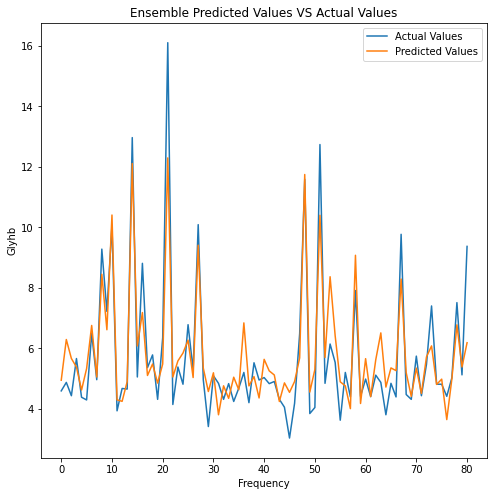

In [ ]:
#Ensemble_average_prediction_2
labels =["Actual Values", "Predicted Values"]
plt.plot(y_test_array)
plt.plot(Ensemble_average_prediction_2)
plt.xlabel("Frequency")
plt.ylabel("Glyhb")
plt.title("Ensemble Predicted Values VS Actual Values")
plt.legend(labels)
plt.show(figsize=(10, 10))



---



# Feature **Importance**

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

### Lasso Important features

In [ ]:
# lasso 
coef = pd.Series(Lasso_best_model.coef_, index = x_train.columns)

NameError: ignored

In [ ]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

NameError: ignored

In [ ]:
imp_coef = pd.concat([coef.sort_values().head(11),
                     coef.sort_values().tail(11)])

In [ ]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

### XGBRegressor

In [ ]:
# XGBRegressor
coef = pd.Series(xgb_best_model.feature_importances_, index = x_train.columns)

In [ ]:
imp_coef = pd.concat([coef.sort_values().head(11),
                     coef.sort_values().tail(11)])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

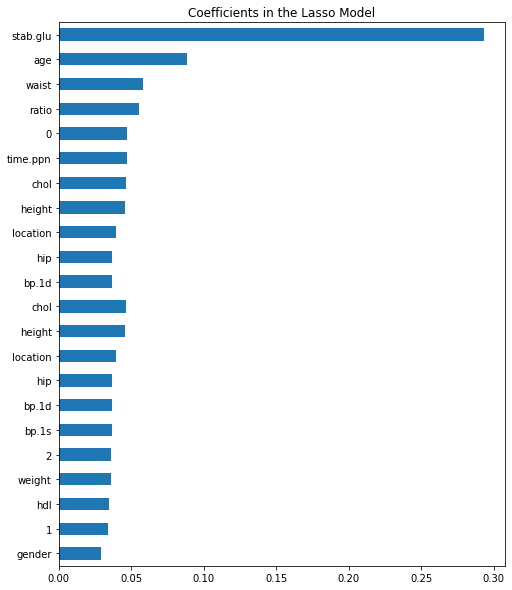

In [ ]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

##  Random forest

In [ ]:
# Random forest
coef = pd.Series(rf.feature_importances_, index = x_train.columns)

In [ ]:
imp_coef = pd.concat([coef.sort_values().head(11),
                     coef.sort_values().tail(11)])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

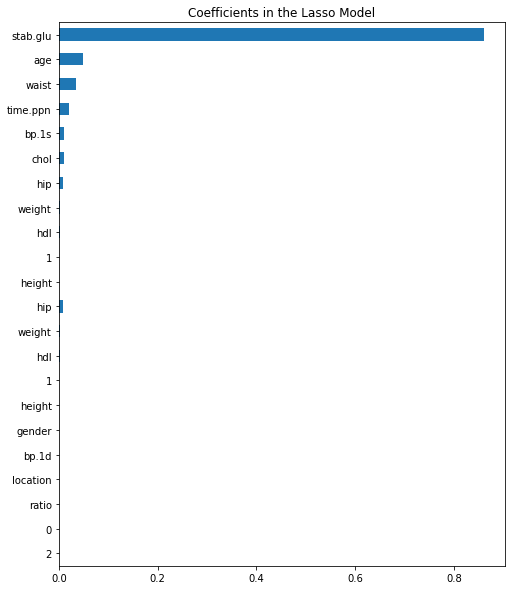

In [ ]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

### Ridge Important features

In [ ]:
# Ridge
coef = pd.Series(Ridge_best_model.coef_, index = x_train.columns)

In [ ]:
imp_coef = pd.concat([coef.sort_values().head(11),
                     coef.sort_values().tail(11)])

Text(0.5, 1.0, 'Coefficients in the Ridge Model')

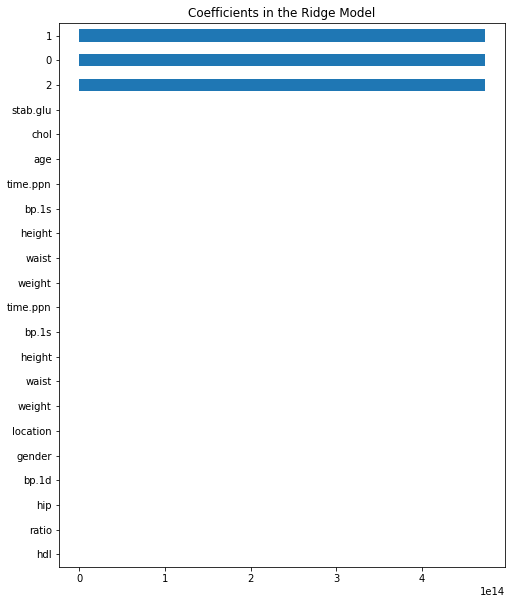

In [ ]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")

In [ ]:
x_train.columns

Index([    'chol', 'stab.glu',      'hdl',    'ratio', 'location',      'age',
         'gender',   'height',   'weight',    'bp.1s',    'bp.1d',    'waist',
            'hip', 'time.ppn',          0,          1,          2],
      dtype='object')

In [ ]:
y_train

353    4.88
233    4.34
3      4.63
18     5.28
131    4.79
       ... 
71     5.23
106    5.17
270    4.62
348    3.98
102    5.44
Name: glyhb, Length: 322, dtype: float64

<Figure size 1440x720 with 0 Axes>

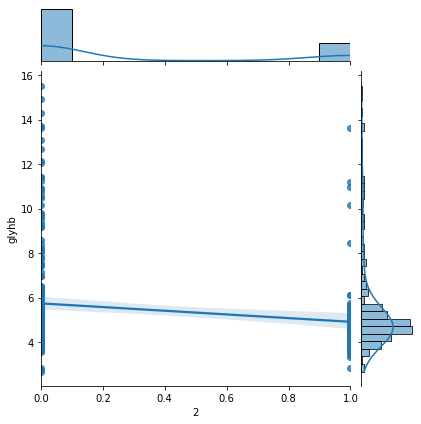

In [ ]:
plt.figure(figsize=(20,10))
sns.jointplot(x=x_train[2],y=y_train,kind="reg")
plt.show()

>4.6, 5.1 = 0.240
>4.9, 6.5 = 2.536
>4.4, 5.8 = 1.780
>5.7, 5.4 = 0.053
>4.4, 4.7 = 0.111
>4.3, 5.3 = 1.120
>6.5, 6.7 = 0.051
>5.0, 5.1 = 0.009
>9.3, 8.8 = 0.209
>7.2, 6.5 = 0.474
>10.1, 10.5 = 0.209
>3.9, 4.5 = 0.317
>4.7, 4.3 = 0.111
>4.7, 5.2 = 0.251
>13.0, 11.8 = 1.430
>5.1, 5.9 = 0.652
>8.8, 7.0 = 3.277
>5.4, 5.4 = 0.000
>5.8, 5.5 = 0.094
>4.3, 4.7 = 0.157
>6.3, 4.9 = 2.180
>16.1, 12.5 = 13.077
>4.1, 4.8 = 0.446
>5.4, 5.3 = 0.004
>4.8, 5.3 = 0.198
>6.8, 6.2 = 0.393
>5.3, 5.1 = 0.021
>10.1, 9.6 = 0.264
>5.0, 5.1 = 0.024
>3.4, 4.8 = 1.955
>5.1, 5.0 = 0.003
>4.8, 3.6 = 1.605
>4.3, 5.1 = 0.601
>4.8, 4.3 = 0.328
>4.2, 5.0 = 0.518
>4.7, 5.0 = 0.084
>5.2, 6.7 = 2.145
>4.2, 4.5 = 0.106
>5.5, 5.0 = 0.241
>4.9, 3.9 = 1.050
>5.0, 5.5 = 0.209
>4.8, 5.0 = 0.028
>4.9, 5.4 = 0.229
>4.3, 4.0 = 0.128
>4.1, 4.8 = 0.496
>3.0, 4.2 = 1.378
>4.2, 4.5 = 0.119
>6.5, 5.6 = 0.694
>11.6, 12.0 = 0.173
>3.8, 4.6 = 0.640
>4.0, 5.4 = 1.816
>12.7, 10.4 = 5.483
>4.8, 5.6 = 0.632
>6.1, 8.7 = 6.706
>5.5, 6.6 = 1.20

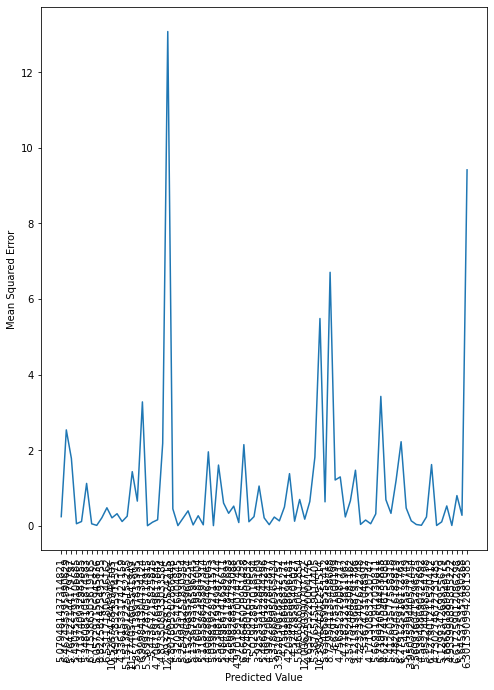

In [ ]:
# Plot for mse 
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
# real value
expected = y_test.to_numpy()
# predicted value
predicted = Ensemble_average_prediction_2
# calculate errors
errors = list()
for i in range(len(expected)):
	# calculate error
	err = (expected[i] - predicted[i])**2
	# store error
	errors.append(err)
	# report error
	print('>%.1f, %.1f = %.3f' % (expected[i], predicted[i], err))
# plot errors
pyplot.plot(errors)
pyplot.xticks(ticks=[i for i in range(len(errors))], labels=predicted)
pyplot.xlabel('Predicted Value')
pyplot.ylabel('Mean Squared Error')
plt.xticks(rotation = 90)
pyplot.show()

In [ ]:
expected

array([ 4.59000015,  4.86999989,  4.42999983,  5.65999985,  4.38000011,
        4.28999996,  6.48999977,  4.96000004,  9.27999973,  7.21999979,
       10.06999969,  3.93000007,  4.67000008,  4.6500001 , 12.97000027,
        5.05000019,  8.81000042,  5.36000013,  5.78000021,  4.30999994,
        6.3499999 , 16.11000061,  4.13999987,  5.38000011,  4.80999994,
        6.78000021,  5.28000021, 10.09000015,  4.96000004,  3.41000009,
        5.09000015,  4.84000015,  4.30999994,  4.82999992,  4.23999977,
        4.67999983,  5.19999981,  4.19999981,  5.51999998,  4.94999981,
        5.03000021,  4.82999992,  4.9000001 ,  4.30999994,  4.05000019,
        3.02999997,  4.17999983,  6.48000002, 11.59000015,  3.83999991,
        4.03999996, 12.73999977,  4.84000015,  6.13999987,  5.53000021,
        3.61999989,  5.19999981,  4.38999987,  7.90999985,  4.40999985,
        4.98000002,  4.4000001 ,  5.11000013,  4.86999989,  3.79999995,
        4.84000015,  4.38999987,  9.77000046,  4.46999979,  4.30

## Elastic Net

### DBSCAN outlier detector ( didnt work)


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [ ]:
dbscan_dataset = dataset[["stab.glu"]]
dbscan_dataset = StandardScaler().fit_transform(dbscan_dataset)

NameError: ignored

In [ ]:
db = DBSCAN(eps=32, min_samples=5).fit(dbscan_dataset)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

In [ ]:
dataset["stab.glu"].head()

In [ ]:
dataset["labels"]=db.labels_

In [ ]:
dataset = dataset[dataset.labels != -1]

In [ ]:
dataset.drop(columns=["labels"],inplace=True)

In [ ]:
# Elastic Net
from numpy import arange
from sklearn.linear_model import ElasticNet
elasticNet_reg = ElasticNet()
params_elastic = {'alpha':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0] , "l1_ratio": arange(0, 1, 0.01)}
elasticNet_GS = GridSearchCV(elasticNet_reg, param_grid=params_elastic, n_jobs=-1)
elasticNet_GS.fit(x_train,y_train)
print(elasticNet_GS.best_params_)
elastic_best_model = elasticNet_GS.best_estimator_
elastic_best_model.fit(x_train,y_train)

In [ ]:
y_elastic_pred= elastic_best_model.predict(x_test)
print(metrics(y_test,y_elastic_pred))

In [ ]:
Ensemble_Weighted_average_prediction_2 = y_Ridge_GS_pred*0.25 + y_lasso_GS_pred*0.5 + y_elastic_pred *0.25
print(metrics(y_test,Ensemble_Weighted_average_prediction_2))

In [ ]:
# add every model's prediction into list
predictions = []
#predictions.append(y_Ridge_GS_pred)
predictions.append(y_rf)
predictions.append(y_lasso_GS_pred)
predictions.append(y_XGBReg_pred)
predictions.append(y_elastic_pred)
#starting Value
starting_values = [0.5]*len(predictions)
cons = ({'type':'eq','fun':lambda w: 1-sum(w)})
#our weights are bound between 0 and 1
bounds = [(0,1)]*len(predictions)
res = minimize(rmse_loss_func, starting_values, method='Powell', bounds=bounds, constraints=cons)


In [ ]:
print('Ensamble Score: {best_score}'.format(best_score=res['fun']))
print('Best Weights: {weights}'.format(weights=res['x']))

In [ ]:
dataset_copy = dataset

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(dataset_copy,y,test_size=0.2,random_state = 42, shuffle = True)

In [ ]:
x_train.head()